# Maximum Likelihood Method
---
This notebook should visualize aspects of different likelihood methods.
## Preparation

In [2]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pprint
import scipy.integrate as integrate

# Set a random seed for the random number generator
rng = np.random.default_rng(seed=1)

# Set the style of the plots
sns.set_theme(context="talk", style="whitegrid")

## 1. Unbinned Logarithmic Likelihood

### Generate Pseudo-Data

For this example we generate $10^6$ events, which are normal distributed with a mean of 2 and a width of 1.

In [3]:
pseudo_data = rng.normal(loc=2, scale=1, size=int(1e6))
pprint.pp(pseudo_data)

array([2.34558419, 2.82161814, 2.33043708, ..., 1.43681935, 2.97471158,
       0.70454646])


### Define the Model Probability Density Function

In general, the model probability density function (PDF) should describe the occurrence probability of a random variable $\vec{x}$ within a certain range $\Delta\vec{x}$. It should describe our data distribution and can also be dependent on model parameters $\vec{\theta}$.

In our case the model PDF is a normal distribution

$$p(x;\sigma,\mu)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

with the random variable $\vec{x}=x$ and model parameters $\vec{\theta}=(\sigma,\mu)^T$.

Now, we define the normal distribution.

In [4]:
def normal_pdf(x: float | np.ndarray, mu: float, sigma: float) -> float | np.ndarray:
    """
    Normal probability density function

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean
        sigma (float): standard deviation

    Returns:
        float | np.ndarray: probability density for the given random variable
    """
    return (
        1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    )

### Plot the Pseudo-Data and Model PDF

bin width: 0.08000000000000007


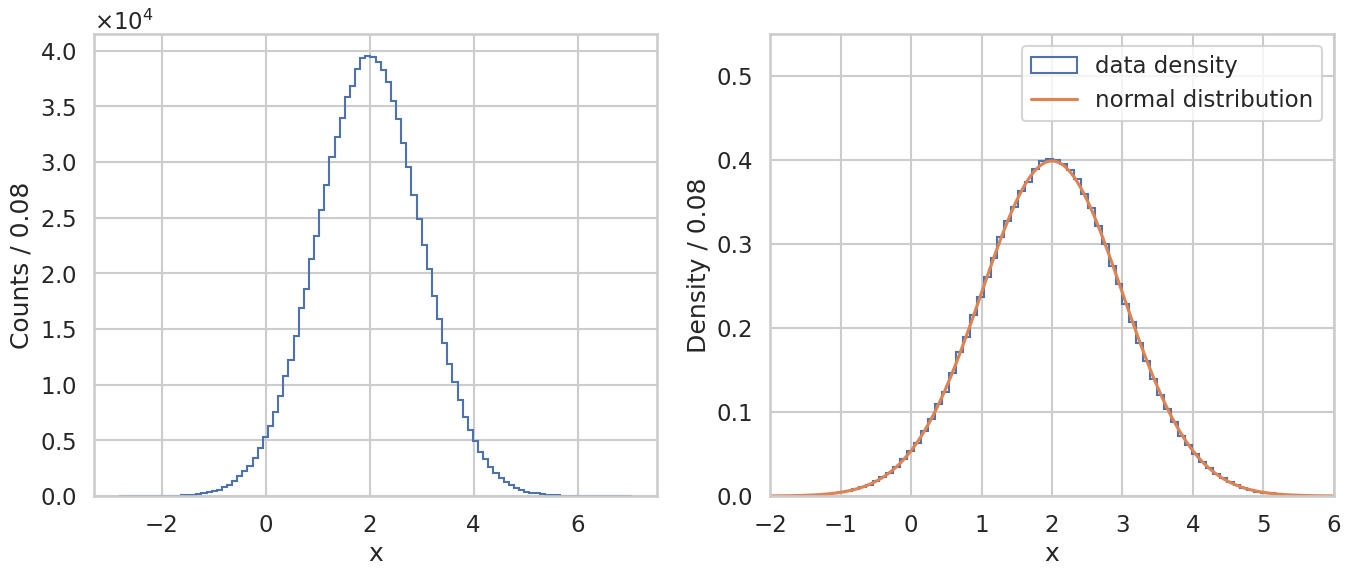

In [5]:
# Define the range of the random variable
x = np.linspace(start=-2, stop=6, num=1000)
# Calculate the probability density function for different values of the random variable
p = normal_pdf(x=x, mu=2, sigma=1)

# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]
print("bin width:", bin_width)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the histogram of the pseudo data
ax[0].hist(x=pseudo_data, bins=100, histtype="step", label="pseudo data")
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[0].set_xlabel("x")
ax[0].set_ylabel(f"Counts / {bin_width:.2f}")

# Plot the density distribution of the pseudo data and the normal distribution
ax[1].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, p, label="normal distribution")
ax[1].set_xlim(-2, 6)
ax[1].set_ylim(0, 0.55)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

### Define the Negative Logarithmic Likelihood Function

The likelihood that a given set of **independent and identically distributed random variables** $\vec{x}$ is distributed according to a model PDF $f(\vec{x};\vec{\theta})$ is given as

$$ \mathcal{L}(\vec{x};\vec{\theta}) = \prod_{i=0}^{N_\text{data}} f(\vec{x}_i;\vec{\theta}). $$

Because multiplying multiple small values between 0 and 1 can lead to values that reach the numerical float limit, usually the logarithm of this function is used. And because one wants to maximize the likelihood to get the right model parameters, but most algorithms are written to minimize a function, one uses the negative logarithmic likelihood:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})}. $$

Lets define that function.

In [6]:
def neg_ln_L(pdf: float | np.ndarray) -> float:
    """
    Negative log-likelihood function

    Args:
        pdf (float | np.ndarray): probability density function

    Returns:
        float: negative log-likelihood
    """
    return -np.sum(np.log(pdf))

### Get the Likelihood of Different Model Parameters

We now want to see how the likelihood function changes for different model parameters. Let's first take a look at the parameters used to generate the data.

In [7]:
# Calculate the negative log-likelihood for the standard deviation and mean of the normal distribution used for the pseudo data
mu = 2
sigma = 1
model_L = neg_ln_L(normal_pdf(x=pseudo_data, mu=mu, sigma=sigma))
print("Negative log-likelihood:", model_L)

Negative log-likelihood: 1417405.5401587742


Now we implement a grind scan for different combinations of $\sigma$ and $\mu$ to see how the likelihood changes in the 2d parameter space

In [8]:
# Define the range of the mean and standard deviation for the grid scan
mu_scan = np.linspace(start=1, stop=3, num=21)
print("First 5 means:", mu_scan[:5])
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)
print("First 5 standard deviations:", sigma_scan[:5])

# Calculate the negative log-likelihood for the grid scan
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L(normal_pdf(x=pseudo_data, mu=mu, sigma=sigma))
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)
print("First 5 negative log-likelihoods: ", neg_ln_L_scan[0][:5])

First 5 means: [1.  1.1 1.2 1.3 1.4]
First 5 standard deviations: [0.5  0.55 0.6  0.65 0.7 ]
First 5 negative log-likelihoods:  [4218823.38777595 3621128.00776412 3181051.82272426 2850896.46630229
 2599524.83167983]


Let's see for which parameters the maximum likelihood (minimum negative log likelihood) was achieved.

In [9]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

Best negative log-likelihood: 1417405.5401587742
Best mu: 2.0
Best sigma: 1.0


We see that the best likelihood was achieved at our input parameters, which is the wanted result.

Now we want to plot the likelihood contours of the parameter space with the results of the grid scan.

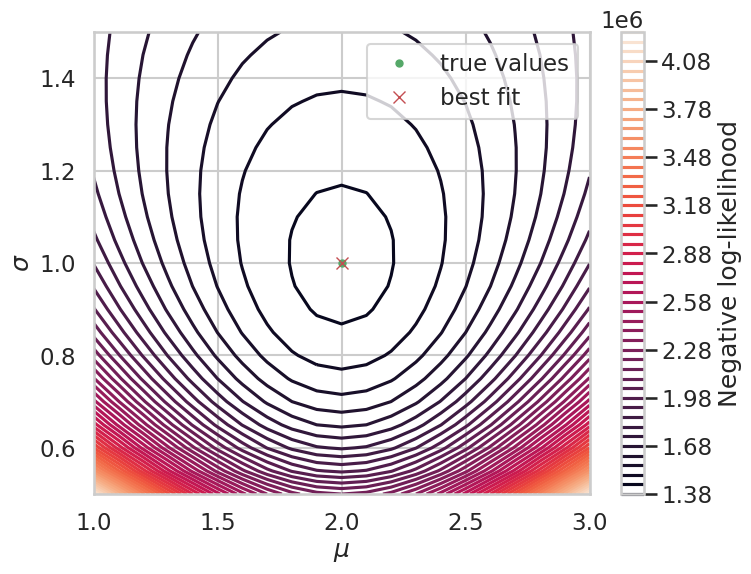

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax.contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax.plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax.plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
fig.colorbar(contour, ax=ax, label="Negative log-likelihood")
ax.legend()
plt.show()

We can see that the contours close in around the true model parameters and that the values seem to diverge for far away mean values.

## 2. Efficiency Correction

The data distributions that we can observe in reality will always be affected by an detection efficiency $\epsilon$, that may also be dependent on the random variable $\vec{x}$. Let's simulate a $x$ dependent efficiency with a linear function.

### Apply Efficiency on Data

We now want to apply an efficiency to our data sample. Let's simulate a $x$ dependent efficiency with a linear function.

In [11]:
def lin_eff(x: np.ndarray | float) -> float | np.ndarray:
    """
    Linear efficiency function defined from x=-3 to x=7. The efficiency is 0 for x < -3 and 1 for x > 7.

    Args:
        x (np.ndarray | float): random variable

    Returns:
        float | np.ndarray: efficiencies for the given random variable
    """
    xmin = -3
    xmax = 7
    return np.where(x < xmin, 0, np.where(x > xmax, 1, (x - xmin) / (xmax - xmin)))

Define a function that randomly removes elements from our data set dependent on our efficiency.

In [12]:
def apply_eff(sample: np.ndarray) -> np.ndarray:
    """
    Apply the efficiency to the sample

    Args:
        sample (np.ndarray): sample to apply the efficiency

    Returns:
        np.ndarray: sample with the efficiency applied
    """
    eff = lin_eff(sample)
    return sample[eff > rng.uniform(size=len(sample))]

Now create our new accepted data sample.

In [13]:
acc_data = apply_eff(pseudo_data)

### Plot the Data with the Applied Efficiency

bin width: 0.08000000000000007


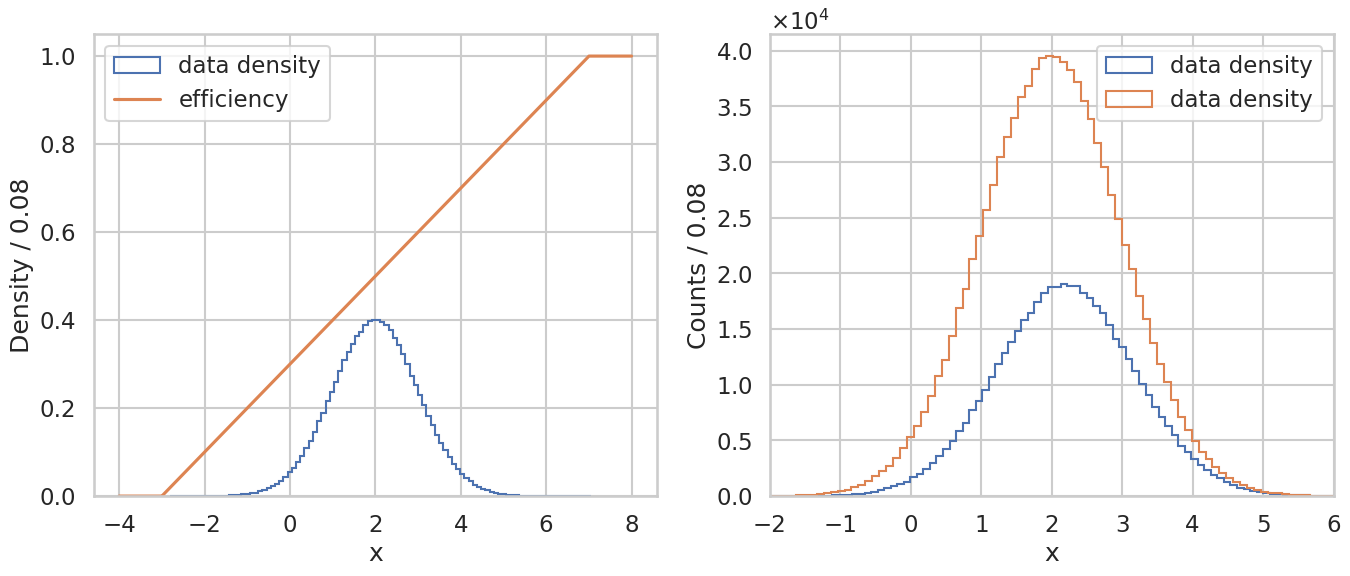

In [14]:
# Define the range of the random variable
x = np.linspace(start=-4, stop=8, num=1000)
# Calculate the efficiency for different values of the random variable
eff = lin_eff(x)

# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]
print("bin width:", bin_width)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the histogram of the pseudo data
ax[0].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[0].plot(x, eff, label="efficiency")
ax[0].set_xlabel("x")
ax[0].set_ylabel(f"Density / {bin_width:.2f}")
ax[0].legend()

# Plot the density distribution of the pseudo data and the normal distribution
ax[1].hist(x=acc_data, bins=100, histtype="step", label="data density")
ax[1].hist(x=pseudo_data, bins=100, histtype="step", label="data density")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[1].set_ylabel(f"Counts / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

### Repeat the Likelihood Grid Scan

We can now repeat the grid search with the accepted data.

In [15]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [neg_ln_L(normal_pdf(x=acc_data, mu=mu, sigma=sigma)) for sigma in sigma_scan]
        for mu in mu_scan
    ]
)

Best negative log-likelihood: 698778.638983082
Best mu: 2.2
Best sigma: 1.0


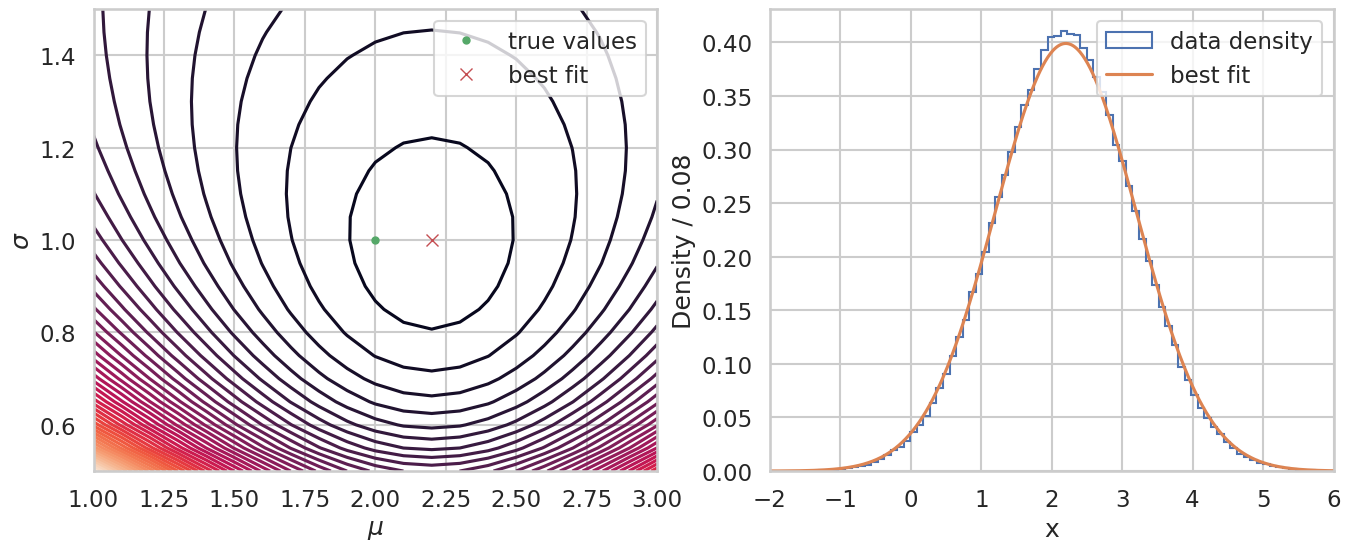

In [16]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=acc_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, normal_pdf(x, mu=best_mu, sigma=best_sigma), label="best fit")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can see that the model parameters with the minimum likelihood describe the accepted data well, even though they are not the parameters with which they were generated. This is the case because our current model does not consider the efficiency.

Next we want to redefine our model PDF to include the efficiency information.

### Efficiency Corrected Model PDF & negative Log-Likelihood

In the ideal case we know the efficiency factor $\epsilon(\vec{x})$. In this case we just need to correct our model PDF and apply a new normalization as follows,

$$ F(\vec{x};\vec{\theta})=\frac{f(\vec{x};\vec{\theta})\epsilon(\vec{x})}{\int f(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x}.$$

The integral for the normalization has to cover the entire phase space of $\vec{x}$, however, because we know that our efficiency is 0 outside of [-3,7], we can use these values as our integration limits. 

So let's define our new PDF.

In [17]:
def normal_pdf_eff(
    x: float | np.ndarray, mu: float, sigma: float
) -> float | np.ndarray:
    """
    Normalized normal distribution with an efficiency factor

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean of the normal distribution
        sigma (float): standard deviation of the normal distribution

    Returns:
        float | np.ndarray: probability density for the given random variable
    """
    return (
        normal_pdf(x=x, mu=mu, sigma=sigma)
        * lin_eff(x)
        / (integrate.quad(lambda x: normal_pdf(x, mu, sigma) * lin_eff(x), -3, 7)[0])
    )

We can also define a new negative log-likelihood by using the logarithm laws:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} - \sum_{i=0}^{N_\text{data}}\ln{\epsilon(\vec{x}_i)} + N_\text{data} \cdot \ln{\left(\int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x\right)}.$$

The fact that $\epsilon(\vec{x})$ is independent from our model parameters means that the summand, which only contains the efficiency, becomes a constant and can be ignored if we search for the minimum negative log-likelihood.

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} + N_\text{data}\cdot\ln{\left(\int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x\right)} + \text{const.}$$

Let's repeat the likelihood grid scan again (redefining the likelihood function here as seen above is not necessary at this step).

In [18]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L(normal_pdf_eff(x=acc_data, mu=mu, sigma=sigma))
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)

Best negative log-likelihood: 698536.4709380021
Best mu: 2.0
Best sigma: 1.0


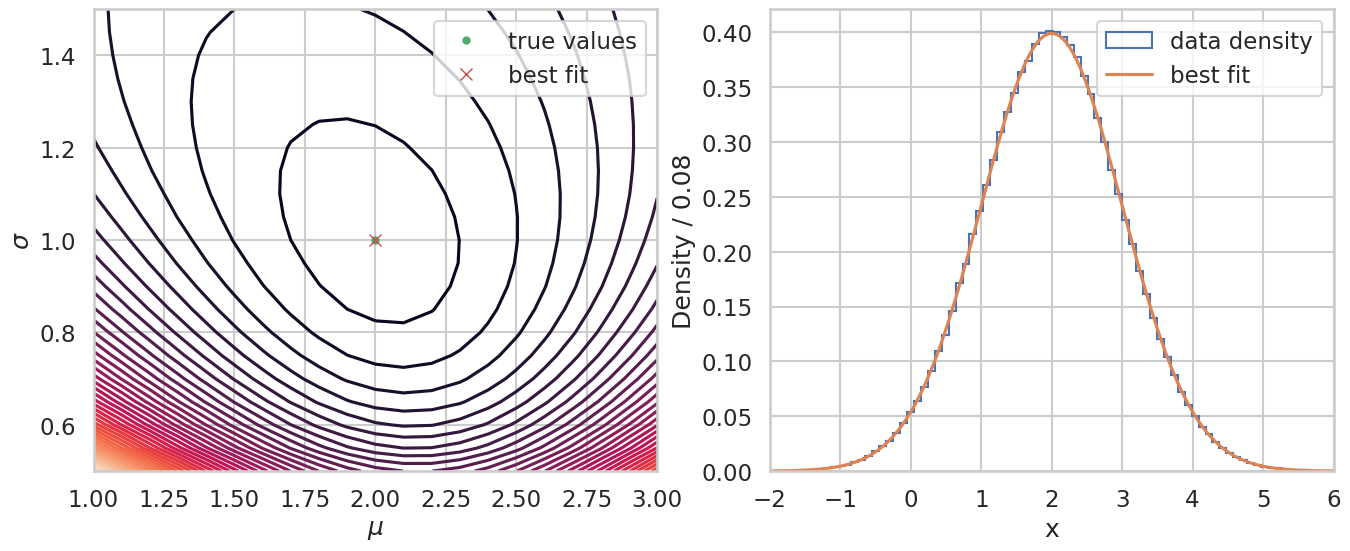

In [19]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, normal_pdf(x, mu=best_mu, sigma=best_sigma), label="best fit")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can see that the new model now gives us again our true model parameters and describes the accepted data distribution well.

### Efficiency Approximation with Simulations

In most cases we do not know our efficiency distribution and thus cannot use the previous method. There is however a way to approximate the integral used for normalization with Simulations.

We use the following relation:

$$ \int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x \propto \frac{1}{N_\text{sim}} \sum_{i=0}^{N_\text{sim}}f(\vec{x}_i;\vec{\theta}), $$

resulting in the new likelihood relation:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} + N_\text{data} \cdot \ln{\left(\sum_{j=0}^{N_\text{sim}}f(\vec{x}_j;\vec{\theta})\right)} + \text{const.} $$

Now we define the new likelihood function.

In [20]:
def neg_ln_L_eff(pdf_data: float | np.ndarray, pdf_sim: float | np.ndarray) -> float:
    """
    Negative log-likelihood function with an efficiency correction estimated with accepted simulation data.

    Args:
        pdf_data (float | np.ndarray): Probabilities of the data according to the model
        pdf_sim (float | np.ndarray): Probabilities of the simulation according to the model

    Returns:
        float: negative log-likelihood
    """
    return -np.sum(np.log(pdf_data)) + len(pdf_data) * np.log(np.sum(pdf_sim))

To use this definition we need to simulate an efficiency accepted sample.

In [21]:
# simulate an even distribution from -3 to 7
sim_data = rng.uniform(low=-3, high=7, size=int(1e7))

# Apply the efficiency to the simulated data
sim_acc_data = apply_eff(sim_data)

Now let's take a look at the samples we have generated.

bin width: 0.08000000000000007


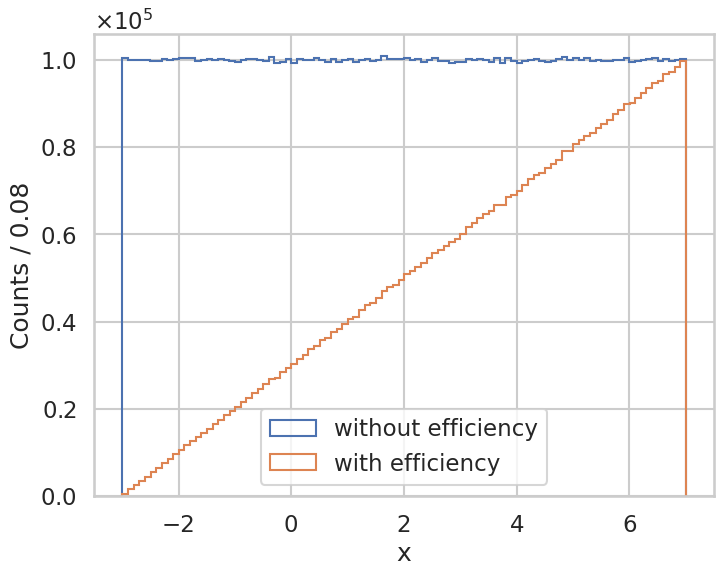

In [22]:
# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]
print("bin width:", bin_width)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram of the pseudo data
ax.hist(x=sim_data, bins=100, histtype="step", label="without efficiency")
ax.hist(x=sim_acc_data, bins=100, histtype="step", label="with efficiency")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.set_xlabel("x")
ax.set_ylabel(f"Counts / {bin_width:.2f}")
ax.legend()

plt.show()

Now we can use the simulations to again make a likelihood scan.

In [23]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L_eff(
                normal_pdf(x=acc_data, mu=mu, sigma=sigma),
                normal_pdf(x=sim_acc_data, mu=mu, sigma=sigma),
            )
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)

And then plot the results. This time we plot the simulated accepted data with weights determined by our model PDF with the best model parameters according to the likelihood scan.

Best negative log-likelihood: 7270534.446552351
Best mu: 2.0
Best sigma: 1.0


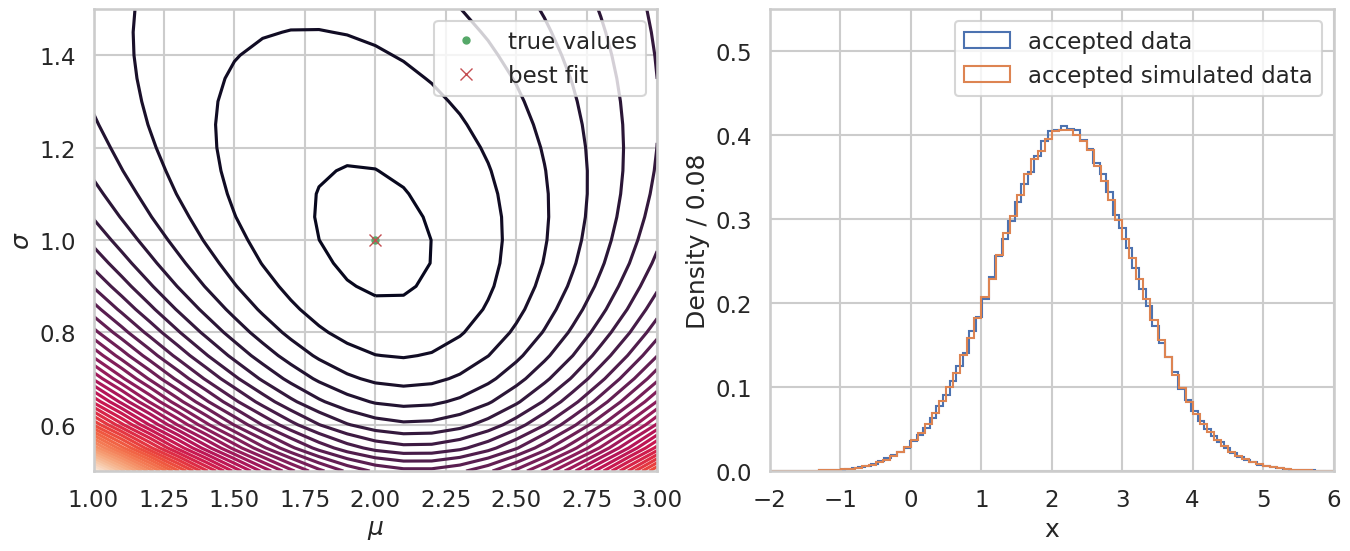

In [24]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=acc_data, bins=100, histtype="step", density=True, label="accepted data")
ax[1].hist(
    x=sim_acc_data,
    weights=normal_pdf(sim_acc_data, best_mu, best_sigma),
    density=True,
    bins=100,
    histtype="step",
    label="accepted simulated data",
)
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylim(0, 0.55)
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can again find our model parameters with the likelihood scan without even knowing the explicit efficiency function, and we can directly compare the fit result to our accepted data.

## 3. Extended Likelihood

With our current model, we only look at data densities at different points in the phase space of $\vec{x}$. However often also the absolute number of events predicted by a model $N_\text{model}(\vec{\theta})$ is of interest. In this case we have to add a term in the likelihood that considers how good $N_\text{model}(\vec{\theta})$ the measured number of data $N_\text{data}$ for a given set of fit parameters $\vec{\theta}$. For this we assume that the probability for measuring $N_\text{model}(\vec{\theta})$ events is normal distributed with a mean of $N_\text{data}$ and a standard deviation of $\sqrt{N_\text{data}}$ yielding the extended likelihood:

$$ \mathcal{L}(\vec{x};\vec{\theta}) = \prod_{i=0}^{N_\text{data}} p(N_\text{model}(\vec{\theta});\sqrt{N_\text{data}},N_\text{data}) F(\vec{x}_i;\vec{\theta}), $$

$$ \mathcal{L}(\vec{x};\vec{\theta}) = \frac{N_\text{data}!}{\sqrt{2\pi N_\text{data}}}e^{-\frac{(N_\text{model}(\vec{\theta})-N_\text{data})^2}{2N_\text{data}}} \prod_{i=0}^{N_\text{data}} F(\vec{x}_i;\vec{\theta}). $$

The factor $N_\text{data}!$ had to be added to the normalization to account for all possible permutations of the elements in the data set.

The negative log-likelihood is then defined as:
$$ -\ln{\mathcal{L}} = - \ln{\frac{N_\text{data}!}{\sqrt{2\pi N_\text{data}}}} + \frac{(N_\text{model}(\vec{\theta})-N_\text{data})^2}{2N_\text{data}} - \sum_{i=0}^{N_\text{data}}\ln{F(\vec{x}_i;\vec{\theta})}, $$

$$ -\ln{\mathcal{L}} = \frac{(N_\text{model}(\vec{\theta})-N_\text{data})^2}{2N_\text{data}} - \sum_{i=0}^{N_\text{data}}\ln{F(\vec{x}_i;\vec{\theta})} + \text{const.} $$

The number of events predicted by our model is nothing else then $N_\text{model}(\vec{\theta}) = \int f(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x$, which we again can approximate using simulations, giving us the following function:

$$ -\ln{\mathcal{L}} = \frac{1}{2N_\text{data}}\left(\frac{1}{N_\text{sim}} \sum_{i=0}^{N_\text{sim}}f(\vec{x}_i;\vec{\theta}) -N_\text{data}\right)^2 - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} + N_\text{data} \cdot \ln{\left(\sum_{j=0}^{N_\text{sim}}f(\vec{x}_j;\vec{\theta})\right)} + \text{const.} $$

So let's implement this new likelihood function:

In [52]:
def ext_neg_ln_L(pdf_data: float | np.ndarray, pdf_sim: float | np.ndarray) -> float:
    """
    Extended negative log-likelihood function with an efficiency correction estimated with accepted simulation data.

    Args:
        pdf_data (float | np.ndarray): Probabilities of the data according to the model
        pdf_sim (float | np.ndarray): Probabilities of the simulation according to the model

    Returns:
        float: negative log-likelihood
    """
    return (
        1.0 / 2.0 * float(len(pdf_data)) * (np.sum(pdf_sim) / float(len(pdf_sim)) - 1.0) ** 2
        - np.sum(np.log(pdf_data))
        + float(len(pdf_data)) * np.log(np.sum(pdf_sim) / float(len(pdf_sim)))
    )

To make this approach work we of cause now have to introduce a parameter that is proportional to the number of events into our model. In our case, we can just multiply a scale factor $N$ to our normalized normal distribution:

In [53]:
def normal_distribution(
    x: float | np.ndarray, mu: float, sigma: float, N: float
) -> float | np.ndarray:
    """
    Normal distribution of N measurements.

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean
        sigma (float): standard deviation
        N (float): number of measurements

    Returns:
        float | np.ndarray: number of events for the given random variable
    """
    return (
        N
        / (np.sqrt(2 * np.pi * sigma**2))
        * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    )

In [54]:
len(acc_data) / len(pseudo_data)
len(sim_acc_data) / len(sim_data)

0.4998271

In [74]:
np.sum(normal_distribution(x=sim_acc_data, mu=2, sigma=1, N=10)) / len(sim_acc_data)

1.000861320095833

4698271.0


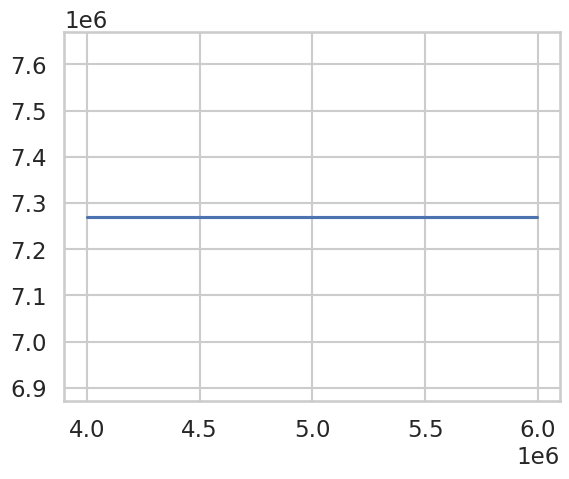

In [56]:
N_scan = np.linspace(start=len(sim_acc_data)-1e6, stop=len(sim_acc_data)+1e6, num=21)
neg_ln_L_vals = [
    neg_ln_L_eff(
        normal_distribution(x=acc_data, mu=2, sigma=1, N=n),
        normal_distribution(x=sim_acc_data, mu=2, sigma=1, N=n),
    )
    for n in N_scan
]
plt.plot(N_scan, neg_ln_L_vals)
print(N_scan[np.argmin(neg_ln_L_vals)])

9.549999999999999
4998271


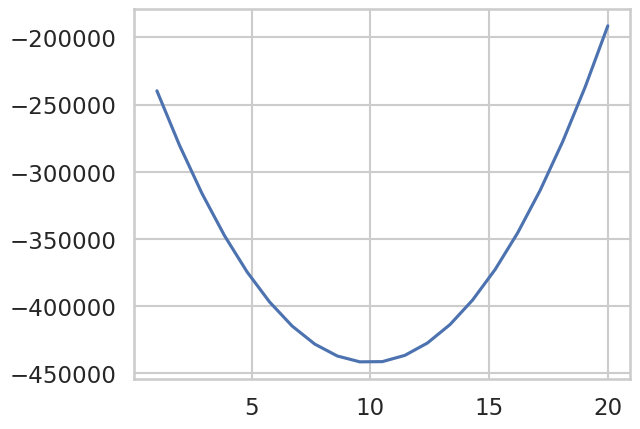

In [57]:
N_scan = np.linspace(start=1, stop=20, num=21)
neg_ln_L_vals = [
    ext_neg_ln_L(
        normal_distribution(x=acc_data, mu=2, sigma=1, N=n),
        normal_distribution(x=sim_acc_data, mu=2, sigma=1, N=n),
    )
    for n in N_scan
]
plt.plot(N_scan, neg_ln_L_vals)
print(N_scan[np.argmin(neg_ln_L_vals)])
print(len(sim_acc_data))

In [63]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
# sigma_scan = np.linspace(start=0.5, stop=1.5, num=11)
sigma_scan = 1
N_scan = np.linspace(start=8, stop=11, num=21)
# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [
            ext_neg_ln_L(
                normal_distribution(x=acc_data, mu=mu, sigma=sigma_scan, N=n),
                normal_distribution(x=sim_acc_data, mu=mu, sigma=sigma_scan, N=n),
            )
            for n in N_scan
        ]
        for mu in mu_scan
    ]
)

Best negative log-likelihood: -442225.30548209214
Best mu: 2.0
Best N: 9.5
True N: 4998271


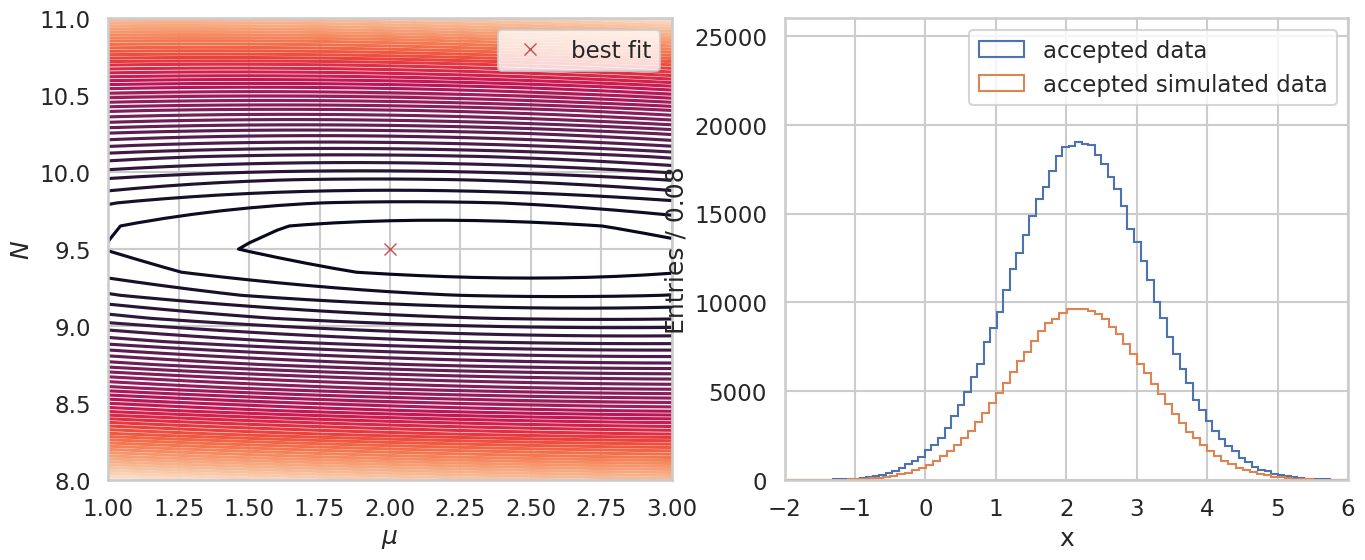

In [72]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_N = N_scan[best_i[0][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best N:", best_N)
print("True N:", len(sim_acc_data))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    N_scan,
    neg_ln_L_scan,
    levels=50,
)
# ax[0].plot(
#     2, len(sim_acc_data), marker="o", ls="", ms=5, color="g", label="true values"
# )
ax[0].plot(best_mu, best_N, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$N$")
ax[0].legend()

ax[1].hist(x=acc_data, bins=100, histtype="step", label="accepted data")
ax[1].hist(
    x=sim_acc_data,
    weights=normal_distribution(sim_acc_data, best_mu, sigma_scan, best_N)
    / len(sim_data)
    * len(acc_data),
    bins=100,
    histtype="step",
    label="accepted simulated data",
)
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylim(0, 2.6e4)
ax[1].set_ylabel(f"Entries / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()